# Graph Characteristics
## Node Characteristics
- Tile Number
- Node Color
- Node Number

## Edge Characteristics
- Edge exists iff 
    - same node number
    - same node color
    - both nodes exist on same x or y axis

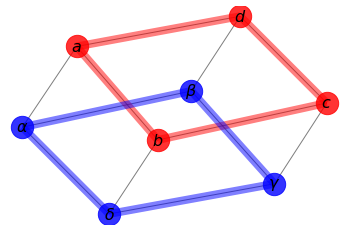

In [4]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.cubical_graph()
pos = nx.spring_layout(G)  # positions for all nodes

# nodes
options = {"node_size": 500, "alpha": 0.8}
nx.draw_networkx_nodes(G, pos, nodelist=[0, 1, 2, 3], node_color="r", **options)
nx.draw_networkx_nodes(G, pos, nodelist=[4, 5, 6, 7], node_color="b", **options)

# edges
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=[(0, 1), (1, 2), (2, 3), (3, 0)],
    width=8,
    alpha=0.5,
    edge_color="r",
)
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=[(4, 5), (5, 6), (6, 7), (7, 4)],
    width=8,
    alpha=0.5,
    edge_color="b",
)


# some math labels
labels = {}
labels[0] = r"$a$"
labels[1] = r"$b$"
labels[2] = r"$c$"
labels[3] = r"$d$"
labels[4] = r"$\alpha$"
labels[5] = r"$\beta$"
labels[6] = r"$\gamma$"
labels[7] = r"$\delta$"
nx.draw_networkx_labels(G, pos, labels, font_size=16)

plt.axis("off")
plt.show()